In [1]:
import os, re, random
from collections import defaultdict
import numpy as np
import pandas as pd
import torch, torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoTokenizer, RobertaModel, get_linear_schedule_with_warmup, AutoModel
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
import json
try:
    import emoji
except Exception:
    emoji = None

In [2]:
BACKBONE = "roberta"
if BACKBONE == "deberta":
    MODEL_NAME = "microsoft/deberta-v3-base"
elif BACKBONE == "roberta":
    MODEL_NAME = "FacebookAI/roberta-base"

SAVE_DIR=f"./{BACKBONE}_lexicon_enhancement"
EMOTIONS_FILE = "emotions.txt"
LEXICON_XLS = "inquireraugmented.xls"

# TRAINING HYPERPARAMETERS
BATCH_SIZE = 32
MAX_LENGTH = 256
NUM_EPOCHS = 1000
LR = 1e-5
DROPOUT = 0.2
SEEDS = [1, 2, 10, 21, 42]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
STOPWORDS_FILE = "Models/data/stopwords.txt"
CONTRACTIONS_FILE = "Models/data/contractions.json"
EMOTICON_FILE = "Models/data/emoticons.json"
SLANG_FILE = "Models/data/slang.json"
EMOTION_TO_GI_FILE = "Models/data/emotion_to_gi.json"

# Stopwords
with open(STOPWORDS_FILE, "r", encoding="utf-8") as f:
    stop_words = set(line.strip().lower() for line in f if line.strip())

# Contractions
with open(CONTRACTIONS_FILE, "r", encoding="utf-8") as f:
    CONTRACTIONS = json.load(f)

# Emoticons
with open(EMOTICON_FILE, "r", encoding="utf-8") as f:
    EMOTICON_MAP = json.load(f)

# Slang
with open(SLANG_FILE, "r", encoding="utf-8") as f:
    SLANG_MAP = json.load(f)

# Emotion → GI features
with open(EMOTION_TO_GI_FILE, "r", encoding="utf-8") as f:
    emotion_to_gi = json.load(f)

punct_keep = set(["!", "?"])

def preprocess_text(text: str, remove_stopwords: bool = False) -> str:
    if not isinstance(text, str):
        text = str(text)

    t = text

    # 1) Replace emojis with text
    if emoji:
        try:
            t = emoji.demojize(t)
        except Exception:
            pass

    # 2) Replace common emoticons
    for emot, rep in EMOTICON_MAP.items():
        t = t.replace(emot, " " + rep + " ")

    # 3) Remove URLs
    t = re.sub(r"""http\S+|www\.\S+""", " ", t)

    # 4) Remove user mentions
    t = re.sub(r"@\w+", " ", t)

    # 5) Keep hashtag words but remove #
    t = re.sub(r"#", "", t)

    # 6) Expand contractions (simple)
    for k, v in CONTRACTIONS.items():
        t = re.sub(re.escape(k), v, t, flags=re.IGNORECASE)

    # 7) Replace slang
    for k, v in SLANG_MAP.items():
        pattern = r"\b" + re.escape(k) + r"\b"
        t = re.sub(pattern, v, t, flags=re.IGNORECASE)

    # 8) Reduce length of repeated chars to max 3 (e.g., loooove -> looove)
    t = re.sub(r"(.)\1{3,}", r"\1\1\1", t)

    # 9) Remove numbers
    t = re.sub(r"\d+", " ", t)

    # 10) Remove punctuation except ! and ?
    # Keep word separators; remove punctuation characters
    t = "".join(ch if ch.isalnum() or ch.isspace() or ch in punct_keep else " " for ch in t)

    # 11) Normalize whitespace
    t = re.sub(r"\s+", " ", t).strip()

    # 12) Tokenize, lemmatize, optional stopword removal
    tokens = re.findall(r"\b\w+\b", t)
    tokens_norm = []
    for token in tokens:
        tok_low = token.lower()
        lemma = tok_low
        if remove_stopwords and lemma in stop_words:
            continue
        tokens_norm.append(lemma)

    return " ".join(tokens_norm)


### GENERAL INQUIRER LEXICON PROCESSING

Functions to load and normalize the General Inquirer sentiment/emotion lexicon from Excel format into a usable dictionary structure.

In [4]:
def normalize_gi_key(name: str) -> str:
    """Normalize GI category names by cleaning and standardizing format."""
    if name is None:
        return ""
    s = str(name).strip()  # Convert to string and remove whitespace
    if s.lower().endswith("_gi"):
        s = s[:-3]  # Remove '_gi' suffix if present
    return s.strip().lower()  # Return lowercase standardized key


def load_gi_lexicons_from_xls(path: str) -> Dict[str, set]:
    """Load GI lexicon from Excel, mapping categories to word sets."""
    xls = pd.ExcelFile(path)
    sheet0 = xls.parse(0)  # Parse first worksheet

    # Ensure first column is named "Entry" for word entries
    if "Entry" not in sheet0.columns:
        sheet0.rename(columns={sheet0.columns[0]: "Entry"}, inplace=True)

    # Build dictionary: normalized_category -> set of words
    gi_lexicons_norm = defaultdict(set)
    for _, row in sheet0.iterrows():
        raw_word = row["Entry"]
        if pd.isna(raw_word):
            continue  # Skip empty rows

        word = str(raw_word).strip().lower()  # Normalize word
        if not word:
            continue

        # Check each category column (all columns after "Entry")
        for col in sheet0.columns[1:]:
            val = row[col]
            # If cell is marked (non-zero, non-NaN), word belongs to this category
            if pd.notna(val) and val != 0:
                canonical = normalize_gi_key(col)  # Normalize category name
                if canonical:
                    gi_lexicons_norm[canonical].add(word)

    # Remove metadata columns that aren't actual lexicon categories
    for meta in ("source", "othrtags", "defined"):
        gi_lexicons_norm.pop(meta, None)

    return dict(gi_lexicons_norm)  # Convert defaultdict to regular dict


def words_for_gi(gi_lexicons_norm: Dict[str, set], gi_name: str) -> List[str]:
    """Retrieve sorted list of words for a specific GI category."""
    key = normalize_gi_key(gi_name)  # Normalize category name for lookup
    return sorted(list(gi_lexicons_norm.get(key, [])))  # Return sorted words or empty list

In [5]:
labels_df = pd.read_csv(EMOTIONS_FILE, header=None)
ID_TO_EMOTION = dict(labels_df[0])
EMOTION_TO_ID = {emotion: emotion_id for emotion_id, emotion in ID_TO_EMOTION.items()}
LABELS = labels_df[0].tolist()
NUM_LABELS = len(LABELS)
gi_lexicons = load_gi_lexicons_from_xls(LEXICON_XLS)

## SEANCE FEATURE EXTRACTION
Implements lexicon-based feature extraction using the General Inquirer (GI) lexicon.

For each emotion, calculates normalized word matching scores to create emotion-specific features.

These features will be concatenated with transformer embeddings as secondary input.

In [6]:
def extract_mapped_emotion_features(text: str) -> np.ndarray:
    """Extract SEANCE features: emotion scores based on GI lexicon matches."""
    tokens = re.findall(r"\b\w+\b", text.lower())
    n = max(1, len(tokens))

    features = []
    for emotion in LABELS:
        gi_features = emotion_to_gi.get(emotion, [])  # Get GI categories mapped to this emotion
        score = 0.0

        for gi in gi_features:
            words = words_for_gi(gi_lexicons, gi)
            if words:
                count = sum(tok in words for tok in tokens)  # Count matching tokens
                score += count / n  # Normalize by text length and accumulate

        features.append(score)

    return np.array(features, dtype=float)

In [7]:
dataset = load_dataset("go_emotions", "simplified")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def encode_go_labels(example):
    one_hot = [0]*NUM_LABELS
    for lab in example["labels"]:
        if 0 <= lab < NUM_LABELS:
            one_hot[lab] = 1
    example["labels_onehot"] = one_hot
    return example

dataset = dataset.map(encode_go_labels, desc="Processing")
train_ds, valid_ds, test_ds = dataset["train"], dataset["validation"], dataset["test"]

### TF-IDF SETUP & SEANCE FEATURE INJECTION
Prepare TF-IDF vectorizer (for potential ablation studies) and add SEANCE (GI) features to all splits.

The SEANCE feature dimension matches the number of emotion labels.

In [8]:
train_texts = [preprocess_text(x["text"]) for x in train_ds]
vectorizer = TfidfVectorizer(vocabulary=set(word for words in gi_lexicons.values() for word in words))
vectorizer.fit(train_texts)

def add_seance(example):
    example["seance"] = extract_mapped_emotion_features(example["text"]).tolist()
    return example

train_ds = train_ds.map(add_seance, desc="Processing train set")
valid_ds = valid_ds.map(add_seance, desc="Processing valid set")
test_ds  = test_ds.map(add_seance, desc="Processing test set")
SEANCE_DIM = NUM_LABELS

### DataLoader collation function
Prepares variable-length text batches by padding, encoding, and extracting labels/SEANCE features

Returns tensors ready for model forward pass

In [9]:
def collate_fn(batch):
    texts = [x["text"] for x in batch]
    enc = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LENGTH)
    labels = torch.tensor([x["labels_onehot"] for x in batch], dtype=torch.float)
    seance = torch.tensor([x["seance"] for x in batch], dtype=torch.float)
    return enc["input_ids"], enc["attention_mask"], seance, labels

### Main neural network architecture
 Combines transformer encoder with SEANCE linguistic features for emotion classification

 SEANCE features are concatenated with CLS token before final classification layer

In [10]:
class TransformerWithSeance(nn.Module):
    def __init__(self, backbone=BACKBONE, model_name=MODEL_NAME,
                 num_labels=NUM_LABELS, seance_dim=SEANCE_DIM, dropout=DROPOUT):
        super().__init__()
        if backbone == "deberta":
            self.encoder = AutoModel.from_pretrained(model_name)
        elif backbone == "roberta":
            self.encoder = RobertaModel.from_pretrained(model_name)
        else:
            raise ValueError("backbone must be 'deberta' or 'roberta'")

        hidden_size = self.encoder.config.hidden_size  # Get embedding dimension from model config
        self.dropout = nn.Dropout(dropout)  # Regularization layer
        self.classifier = nn.Linear(hidden_size + seance_dim, num_labels)  # Output layer with fused features
        nn.init.normal_(self.classifier.weight, std=0.02)  # Initialize weights for stable training

    def forward(self, input_ids, attention_mask, seance_features):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)  # Get transformer representations
        cls = out.last_hidden_state[:, 0, :]  # Extract CLS token
        combined = torch.cat([cls, seance_features.to(cls.dtype)], dim=1)  # Fuse CLS and SEANCE features
        combined = self.dropout(combined)
        return self.classifier(combined)  # Return logits for each emotion class

### Class weight calculator for imbalanced datasets
 Computes inverse frequency weights to prevent bias toward majority emotion classes

In [11]:
def compute_class_weights(train_loader):
    all_labels = []
    for _,_,_, labels in train_loader:
        all_labels.append(labels)
    all_labels = torch.cat(all_labels, dim=0)
    pos_counts = all_labels.sum(0)
    total = len(all_labels)
    weights = total / (NUM_LABELS * pos_counts + 1e-6)
    return weights.to(DEVICE)

### Global threshold optimizer
Finds single threshold that maximizes macro F1 across all emotion classes

In [12]:
def tune_thresholds(logits, labels, n_steps=50):
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    labels = np.array(labels)
    thresholds = np.linspace(0.1, 0.9, n_steps)

    best_f1, best_t = 0, 0.5
    for t in thresholds:
        preds = (probs > t).astype(int)
        f1 = f1_score(labels, preds, average="macro", zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t

    return best_t

# Per-class threshold optimizer

Finds independent thresholds for each emotion class to handle class-specific distributions

More flexible than global threshold for imbalanced multi-label problems

In [13]:
def tune_thresholds_per_class(logits, labels, n_steps=100):
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    labels = np.array(labels)
    thresholds = []
    for c in range(labels.shape[1]):
        best_t, best_f1 = 0.5, 0
        for t in np.linspace(0.01, 0.99, n_steps):
            preds = (probs[:,c]>t).astype(int)
            f1 = f1_score(labels[:,c], preds, zero_division=0)
            if f1 > best_f1:
                best_f1, best_t = f1, t
        thresholds.append(best_t)
    return thresholds

# MODEL TRAINING AND EVALUATION PIPELINE
Trains the transformer model with early stopping, evaluates on validation set,tunes per-class thresholds, saves model and detailed results.

In [14]:
def train_and_eval(seed, save_dir):
    # Set seeds for reproducible training
    torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)

    # Initialize model and move to GPU/CPU; prepare data loaders with collation
    model=TransformerWithSeance(backbone=BACKBONE).to(DEVICE)
    train_loader=DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_fn)
    valid_loader=DataLoader(valid_ds,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn)

    # Compute class weights to address label imbalance; setup optimizer and LR scheduler
    class_weights=compute_class_weights(train_loader)
    optimizer=torch.optim.AdamW(model.parameters(),lr=LR,weight_decay=0.01)
    total_steps=NUM_EPOCHS*len(train_loader)
    scheduler=get_linear_schedule_with_warmup(optimizer,int(0.1*total_steps),total_steps)  # 10% warmup

    # Use BCE loss with logits for multi-label classification
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)

    # Early stopping: track best validation loss with 3-epoch patience and small epsilon
    best_val_loss=float("inf"); patience,p_count=3,0
    train_losses,val_losses=[],[]

    # Main training loop
    for epoch in range(NUM_EPOCHS):
        # Training phase
        model.train(); total_loss=0
        for input_ids,attn,seance,labels in tqdm(train_loader,desc=f"Seed {seed} Epoch {epoch+1}"):
            input_ids,attn,seance,labels=input_ids.to(DEVICE),attn.to(DEVICE),seance.to(DEVICE),labels.to(DEVICE)
            optimizer.zero_grad(); logits=model(input_ids,attn,seance)
            loss=loss_fn(logits,labels); loss.backward(); optimizer.step(); scheduler.step()
            total_loss+=loss.item()
        train_losses.append(total_loss/len(train_loader))

        # Validation phase
        model.eval(); val_loss=0
        with torch.no_grad():
            for input_ids,attn,seance,labels in valid_loader:
                input_ids,attn,seance,labels=input_ids.to(DEVICE),attn.to(DEVICE),seance.to(DEVICE),labels.to(DEVICE)
                logits=model(input_ids,attn,seance)
                loss=loss_fn(logits,labels); val_loss+=loss.item()
        val_loss/=len(valid_loader); val_losses.append(val_loss)
        print(f"Seed {seed} Epoch {epoch+1}: Train {train_losses[-1]:.4f}, Val {val_loss:.4f}")

        # Early stopping check: stop if no improvement after 3 epochs
        epsilon = 1e-4
        if val_loss < best_val_loss - epsilon:
            best_val_loss = val_loss
            p_count = 0
        else:
            p_count += 1
            print(f"No improvement ({p_count}/{patience})")
            if p_count >= patience:
                print(f"⚠️ Early stopping at epoch {epoch+1}")
                break

    # Final evaluation: collect predictions, tune per-class thresholds, compute metrics
    all_logits,all_labels,all_texts,all_seance=[],[],[],[]
    model.eval()
    with torch.no_grad():
        for input_ids,attn,seance,labels in valid_loader:
            input_ids,attn,seance=input_ids.to(DEVICE),attn.to(DEVICE),seance.to(DEVICE)
            logits=model(input_ids,attn,seance)
            all_logits.append(logits.cpu().numpy()); all_labels.append(labels.numpy())
            all_texts.extend(tokenizer.batch_decode(input_ids,skip_special_tokens=True))
            all_seance.extend(seance.cpu().numpy().tolist())
    all_logits,all_labels=np.vstack(all_logits),np.vstack(all_labels)
    per_class_thresholds = tune_thresholds_per_class(all_logits, all_labels)  # Optimal thresholds per emotion

    # Apply thresholds to sigmoid probabilities to get final predictions
    probs=torch.sigmoid(torch.tensor(all_logits)).numpy()
    tuned_preds=np.zeros_like(probs,dtype=int)
    for c,t in enumerate(per_class_thresholds):
        tuned_preds[:,c] = (probs[:,c] > t).astype(int)

    # Calculate macro-averaged metrics across all emotion classes
    f1=f1_score(all_labels,tuned_preds,average="macro",zero_division=0)
    prec=precision_score(all_labels,tuned_preds,average="macro",zero_division=0)
    rec=recall_score(all_labels,tuned_preds,average="macro",zero_division=0)
    print(f"Seed {seed}: F1={f1:.4f} Prec={prec:.4f} Rec={rec:.4f}")

    # Save model weights, per-class metrics, and detailed predictions
    seed_dir=os.path.join(save_dir,f"seed_{seed}"); os.makedirs(seed_dir,exist_ok=True)
    torch.save(model.state_dict(),os.path.join(seed_dir,"pytorch_model.bin"))
    metrics=[{"Emotion":emo,"F1Score":f1_score(all_labels[:,uid],tuned_preds[:,uid],zero_division=0)} for emo,uid in EMOTION_TO_ID.items()]
    pd.DataFrame(metrics).to_csv(os.path.join(seed_dir,"metrics.csv"),index=False)
    pd.DataFrame({"text":all_texts,"true_labels":all_labels.tolist(),"sota_labels":tuned_preds.tolist(),"seance":all_seance}).to_csv(os.path.join(seed_dir,"results.csv"),sep=";",index=False)

    # Cleanup: free GPU memory and return final metrics
    del model,optimizer,scheduler; torch.cuda.empty_cache()
    return f1,prec,rec,train_losses,val_losses

### Training the model, plotting training and validation loss curves

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Seed 1 Epoch 1: 100%|██████████| 1357/1357 [02:15<00:00, 10.04it/s]


Seed 1 Epoch 1: Train 0.6475, Val 0.6134


Seed 1 Epoch 2: 100%|██████████| 1357/1357 [02:20<00:00,  9.64it/s]


Seed 1 Epoch 2: Train 0.3423, Val 0.2197


Seed 1 Epoch 3: 100%|██████████| 1357/1357 [02:20<00:00,  9.65it/s]


Seed 1 Epoch 3: Train 0.2150, Val 0.1831


Seed 1 Epoch 4: 100%|██████████| 1357/1357 [02:21<00:00,  9.60it/s]


Seed 1 Epoch 4: Train 0.1871, Val 0.1699


Seed 1 Epoch 5: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 1 Epoch 5: Train 0.1735, Val 0.1624


Seed 1 Epoch 6: 100%|██████████| 1357/1357 [02:22<00:00,  9.55it/s]


Seed 1 Epoch 6: Train 0.1643, Val 0.1553


Seed 1 Epoch 7: 100%|██████████| 1357/1357 [02:21<00:00,  9.57it/s]


Seed 1 Epoch 7: Train 0.1544, Val 0.1421


Seed 1 Epoch 8: 100%|██████████| 1357/1357 [02:21<00:00,  9.60it/s]


Seed 1 Epoch 8: Train 0.1413, Val 0.1282


Seed 1 Epoch 9: 100%|██████████| 1357/1357 [02:22<00:00,  9.53it/s]


Seed 1 Epoch 9: Train 0.1290, Val 0.1167


Seed 1 Epoch 10: 100%|██████████| 1357/1357 [02:22<00:00,  9.55it/s]


Seed 1 Epoch 10: Train 0.1188, Val 0.1084


Seed 1 Epoch 11: 100%|██████████| 1357/1357 [02:22<00:00,  9.52it/s]


Seed 1 Epoch 11: Train 0.1103, Val 0.1019


Seed 1 Epoch 12: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 1 Epoch 12: Train 0.1034, Val 0.0970


Seed 1 Epoch 13: 100%|██████████| 1357/1357 [02:22<00:00,  9.53it/s]


Seed 1 Epoch 13: Train 0.0981, Val 0.0938


Seed 1 Epoch 14: 100%|██████████| 1357/1357 [02:22<00:00,  9.53it/s]


Seed 1 Epoch 14: Train 0.0934, Val 0.0906


Seed 1 Epoch 15: 100%|██████████| 1357/1357 [02:22<00:00,  9.53it/s]


Seed 1 Epoch 15: Train 0.0895, Val 0.0879


Seed 1 Epoch 16: 100%|██████████| 1357/1357 [02:22<00:00,  9.51it/s]


Seed 1 Epoch 16: Train 0.0863, Val 0.0859


Seed 1 Epoch 17: 100%|██████████| 1357/1357 [02:22<00:00,  9.52it/s]


Seed 1 Epoch 17: Train 0.0836, Val 0.0853


Seed 1 Epoch 18: 100%|██████████| 1357/1357 [02:22<00:00,  9.53it/s]


Seed 1 Epoch 18: Train 0.0810, Val 0.0838


Seed 1 Epoch 19: 100%|██████████| 1357/1357 [02:22<00:00,  9.51it/s]


Seed 1 Epoch 19: Train 0.0784, Val 0.0839
No improvement (1/3)


Seed 1 Epoch 20: 100%|██████████| 1357/1357 [02:22<00:00,  9.52it/s]


Seed 1 Epoch 20: Train 0.0765, Val 0.0822


Seed 1 Epoch 21: 100%|██████████| 1357/1357 [02:21<00:00,  9.56it/s]


Seed 1 Epoch 21: Train 0.0741, Val 0.0829
No improvement (1/3)


Seed 1 Epoch 22: 100%|██████████| 1357/1357 [02:22<00:00,  9.53it/s]


Seed 1 Epoch 22: Train 0.0724, Val 0.0826
No improvement (2/3)


Seed 1 Epoch 23: 100%|██████████| 1357/1357 [02:22<00:00,  9.51it/s]


Seed 1 Epoch 23: Train 0.0705, Val 0.0821


Seed 1 Epoch 24: 100%|██████████| 1357/1357 [02:22<00:00,  9.50it/s]


Seed 1 Epoch 24: Train 0.0688, Val 0.0828
No improvement (1/3)


Seed 1 Epoch 25: 100%|██████████| 1357/1357 [02:22<00:00,  9.53it/s]


Seed 1 Epoch 25: Train 0.0669, Val 0.0834
No improvement (2/3)


Seed 1 Epoch 26: 100%|██████████| 1357/1357 [02:22<00:00,  9.51it/s]


Seed 1 Epoch 26: Train 0.0656, Val 0.0833
No improvement (3/3)
⚠️ Early stopping at epoch 26
Seed 1: F1=0.5504 Prec=0.5571 Rec=0.5812


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Seed 2 Epoch 1: 100%|██████████| 1357/1357 [02:21<00:00,  9.60it/s]


Seed 2 Epoch 1: Train 0.6876, Val 0.6533


Seed 2 Epoch 2: 100%|██████████| 1357/1357 [02:22<00:00,  9.52it/s]


Seed 2 Epoch 2: Train 0.3886, Val 0.2156


Seed 2 Epoch 3: 100%|██████████| 1357/1357 [02:22<00:00,  9.53it/s]


Seed 2 Epoch 3: Train 0.2116, Val 0.1792


Seed 2 Epoch 4: 100%|██████████| 1357/1357 [02:22<00:00,  9.52it/s]


Seed 2 Epoch 4: Train 0.1834, Val 0.1667


Seed 2 Epoch 5: 100%|██████████| 1357/1357 [02:22<00:00,  9.51it/s]


Seed 2 Epoch 5: Train 0.1707, Val 0.1602


Seed 2 Epoch 6: 100%|██████████| 1357/1357 [02:22<00:00,  9.52it/s]


Seed 2 Epoch 6: Train 0.1628, Val 0.1552


Seed 2 Epoch 7: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 2 Epoch 7: Train 0.1553, Val 0.1446


Seed 2 Epoch 8: 100%|██████████| 1357/1357 [02:22<00:00,  9.52it/s]


Seed 2 Epoch 8: Train 0.1425, Val 0.1288


Seed 2 Epoch 9: 100%|██████████| 1357/1357 [02:22<00:00,  9.51it/s]


Seed 2 Epoch 9: Train 0.1292, Val 0.1159


Seed 2 Epoch 10: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 2 Epoch 10: Train 0.1181, Val 0.1078


Seed 2 Epoch 11: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 2 Epoch 11: Train 0.1098, Val 0.1009


Seed 2 Epoch 12: 100%|██████████| 1357/1357 [02:22<00:00,  9.52it/s]


Seed 2 Epoch 12: Train 0.1033, Val 0.0967


Seed 2 Epoch 13: 100%|██████████| 1357/1357 [02:22<00:00,  9.52it/s]


Seed 2 Epoch 13: Train 0.0979, Val 0.0921


Seed 2 Epoch 14: 100%|██████████| 1357/1357 [02:22<00:00,  9.52it/s]


Seed 2 Epoch 14: Train 0.0934, Val 0.0895


Seed 2 Epoch 15: 100%|██████████| 1357/1357 [02:22<00:00,  9.52it/s]


Seed 2 Epoch 15: Train 0.0896, Val 0.0874


Seed 2 Epoch 16: 100%|██████████| 1357/1357 [02:22<00:00,  9.53it/s]


Seed 2 Epoch 16: Train 0.0866, Val 0.0861


Seed 2 Epoch 17: 100%|██████████| 1357/1357 [02:22<00:00,  9.53it/s]


Seed 2 Epoch 17: Train 0.0837, Val 0.0846


Seed 2 Epoch 18: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 2 Epoch 18: Train 0.0809, Val 0.0844


Seed 2 Epoch 19: 100%|██████████| 1357/1357 [02:22<00:00,  9.50it/s]


Seed 2 Epoch 19: Train 0.0788, Val 0.0831


Seed 2 Epoch 20: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 2 Epoch 20: Train 0.0764, Val 0.0819


Seed 2 Epoch 21: 100%|██████████| 1357/1357 [02:22<00:00,  9.53it/s]


Seed 2 Epoch 21: Train 0.0746, Val 0.0822
No improvement (1/3)


Seed 2 Epoch 22: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 2 Epoch 22: Train 0.0723, Val 0.0818


Seed 2 Epoch 23: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 2 Epoch 23: Train 0.0706, Val 0.0819
No improvement (1/3)


Seed 2 Epoch 24: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 2 Epoch 24: Train 0.0687, Val 0.0821
No improvement (2/3)


Seed 2 Epoch 25: 100%|██████████| 1357/1357 [02:21<00:00,  9.56it/s]


Seed 2 Epoch 25: Train 0.0672, Val 0.0827
No improvement (3/3)
⚠️ Early stopping at epoch 25
Seed 2: F1=0.5493 Prec=0.5579 Rec=0.5736


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Seed 10 Epoch 1: 100%|██████████| 1357/1357 [02:22<00:00,  9.49it/s]


Seed 10 Epoch 1: Train 0.6948, Val 0.6716


Seed 10 Epoch 2: 100%|██████████| 1357/1357 [02:22<00:00,  9.52it/s]


Seed 10 Epoch 2: Train 0.4226, Val 0.2261


Seed 10 Epoch 3: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 10 Epoch 3: Train 0.2202, Val 0.1846


Seed 10 Epoch 4: 100%|██████████| 1357/1357 [02:21<00:00,  9.57it/s]


Seed 10 Epoch 4: Train 0.1886, Val 0.1704


Seed 10 Epoch 5: 100%|██████████| 1357/1357 [02:22<00:00,  9.53it/s]


Seed 10 Epoch 5: Train 0.1742, Val 0.1624


Seed 10 Epoch 6: 100%|██████████| 1357/1357 [02:22<00:00,  9.51it/s]


Seed 10 Epoch 6: Train 0.1653, Val 0.1565


Seed 10 Epoch 7: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 10 Epoch 7: Train 0.1570, Val 0.1463


Seed 10 Epoch 8: 100%|██████████| 1357/1357 [02:22<00:00,  9.51it/s]


Seed 10 Epoch 8: Train 0.1448, Val 0.1325


Seed 10 Epoch 9: 100%|██████████| 1357/1357 [02:22<00:00,  9.51it/s]


Seed 10 Epoch 9: Train 0.1321, Val 0.1193


Seed 10 Epoch 10: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 10 Epoch 10: Train 0.1214, Val 0.1102


Seed 10 Epoch 11: 100%|██████████| 1357/1357 [02:22<00:00,  9.53it/s]


Seed 10 Epoch 11: Train 0.1126, Val 0.1029


Seed 10 Epoch 12: 100%|██████████| 1357/1357 [02:22<00:00,  9.52it/s]


Seed 10 Epoch 12: Train 0.1055, Val 0.0981


Seed 10 Epoch 13: 100%|██████████| 1357/1357 [02:22<00:00,  9.50it/s]


Seed 10 Epoch 13: Train 0.0999, Val 0.0937


Seed 10 Epoch 14: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 10 Epoch 14: Train 0.0951, Val 0.0901


Seed 10 Epoch 15: 100%|██████████| 1357/1357 [02:22<00:00,  9.52it/s]


Seed 10 Epoch 15: Train 0.0909, Val 0.0883


Seed 10 Epoch 16: 100%|██████████| 1357/1357 [02:21<00:00,  9.57it/s]


Seed 10 Epoch 16: Train 0.0875, Val 0.0860


Seed 10 Epoch 17: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 10 Epoch 17: Train 0.0845, Val 0.0857


Seed 10 Epoch 18: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 10 Epoch 18: Train 0.0819, Val 0.0832


Seed 10 Epoch 19: 100%|██████████| 1357/1357 [02:22<00:00,  9.52it/s]


Seed 10 Epoch 19: Train 0.0794, Val 0.0839
No improvement (1/3)


Seed 10 Epoch 20: 100%|██████████| 1357/1357 [02:22<00:00,  9.52it/s]


Seed 10 Epoch 20: Train 0.0771, Val 0.0819


Seed 10 Epoch 21: 100%|██████████| 1357/1357 [02:22<00:00,  9.51it/s]


Seed 10 Epoch 21: Train 0.0750, Val 0.0814


Seed 10 Epoch 22: 100%|██████████| 1357/1357 [02:22<00:00,  9.52it/s]


Seed 10 Epoch 22: Train 0.0731, Val 0.0814
No improvement (1/3)


Seed 10 Epoch 23: 100%|██████████| 1357/1357 [02:22<00:00,  9.52it/s]


Seed 10 Epoch 23: Train 0.0711, Val 0.0811


Seed 10 Epoch 24: 100%|██████████| 1357/1357 [02:21<00:00,  9.57it/s]


Seed 10 Epoch 24: Train 0.0694, Val 0.0821
No improvement (1/3)


Seed 10 Epoch 25: 100%|██████████| 1357/1357 [02:22<00:00,  9.53it/s]


Seed 10 Epoch 25: Train 0.0675, Val 0.0819
No improvement (2/3)


Seed 10 Epoch 26: 100%|██████████| 1357/1357 [02:22<00:00,  9.52it/s]


Seed 10 Epoch 26: Train 0.0659, Val 0.0825
No improvement (3/3)
⚠️ Early stopping at epoch 26
Seed 10: F1=0.5504 Prec=0.5512 Rec=0.5806


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Seed 21 Epoch 1: 100%|██████████| 1357/1357 [02:22<00:00,  9.53it/s]


Seed 21 Epoch 1: Train 0.6451, Val 0.6208


Seed 21 Epoch 2: 100%|██████████| 1357/1357 [02:21<00:00,  9.56it/s]


Seed 21 Epoch 2: Train 0.3742, Val 0.2318


Seed 21 Epoch 3: 100%|██████████| 1357/1357 [02:22<00:00,  9.53it/s]


Seed 21 Epoch 3: Train 0.2259, Val 0.1894


Seed 21 Epoch 4: 100%|██████████| 1357/1357 [02:22<00:00,  9.52it/s]


Seed 21 Epoch 4: Train 0.1932, Val 0.1736


Seed 21 Epoch 5: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 21 Epoch 5: Train 0.1774, Val 0.1642


Seed 21 Epoch 6: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 21 Epoch 6: Train 0.1667, Val 0.1562


Seed 21 Epoch 7: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 21 Epoch 7: Train 0.1565, Val 0.1452


Seed 21 Epoch 8: 100%|██████████| 1357/1357 [02:22<00:00,  9.52it/s]


Seed 21 Epoch 8: Train 0.1440, Val 0.1316


Seed 21 Epoch 9: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 21 Epoch 9: Train 0.1321, Val 0.1203


Seed 21 Epoch 10: 100%|██████████| 1357/1357 [02:22<00:00,  9.53it/s]


Seed 21 Epoch 10: Train 0.1214, Val 0.1103


Seed 21 Epoch 11: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 21 Epoch 11: Train 0.1126, Val 0.1031


Seed 21 Epoch 12: 100%|██████████| 1357/1357 [02:22<00:00,  9.53it/s]


Seed 21 Epoch 12: Train 0.1052, Val 0.0970


Seed 21 Epoch 13: 100%|██████████| 1357/1357 [02:22<00:00,  9.55it/s]


Seed 21 Epoch 13: Train 0.0996, Val 0.0933


Seed 21 Epoch 14: 100%|██████████| 1357/1357 [02:22<00:00,  9.55it/s]


Seed 21 Epoch 14: Train 0.0947, Val 0.0905


Seed 21 Epoch 15: 100%|██████████| 1357/1357 [02:22<00:00,  9.53it/s]


Seed 21 Epoch 15: Train 0.0907, Val 0.0886


Seed 21 Epoch 16: 100%|██████████| 1357/1357 [02:22<00:00,  9.53it/s]


Seed 21 Epoch 16: Train 0.0875, Val 0.0861


Seed 21 Epoch 17: 100%|██████████| 1357/1357 [02:22<00:00,  9.51it/s]


Seed 21 Epoch 17: Train 0.0843, Val 0.0849


Seed 21 Epoch 18: 100%|██████████| 1357/1357 [02:22<00:00,  9.52it/s]


Seed 21 Epoch 18: Train 0.0818, Val 0.0843


Seed 21 Epoch 19: 100%|██████████| 1357/1357 [02:22<00:00,  9.52it/s]


Seed 21 Epoch 19: Train 0.0796, Val 0.0829


Seed 21 Epoch 20: 100%|██████████| 1357/1357 [02:22<00:00,  9.56it/s]


Seed 21 Epoch 20: Train 0.0771, Val 0.0822


Seed 21 Epoch 21: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 21 Epoch 21: Train 0.0753, Val 0.0816


Seed 21 Epoch 22: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 21 Epoch 22: Train 0.0734, Val 0.0821
No improvement (1/3)


Seed 21 Epoch 23: 100%|██████████| 1357/1357 [02:22<00:00,  9.53it/s]


Seed 21 Epoch 23: Train 0.0714, Val 0.0828
No improvement (2/3)


Seed 21 Epoch 24: 100%|██████████| 1357/1357 [02:22<00:00,  9.51it/s]


Seed 21 Epoch 24: Train 0.0697, Val 0.0817
No improvement (3/3)
⚠️ Early stopping at epoch 24
Seed 21: F1=0.5536 Prec=0.5641 Rec=0.5712


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Seed 42 Epoch 1: 100%|██████████| 1357/1357 [02:22<00:00,  9.53it/s]


Seed 42 Epoch 1: Train 0.6973, Val 0.6494


Seed 42 Epoch 2: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 42 Epoch 2: Train 0.3362, Val 0.2145


Seed 42 Epoch 3: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 42 Epoch 3: Train 0.2103, Val 0.1796


Seed 42 Epoch 4: 100%|██████████| 1357/1357 [02:22<00:00,  9.52it/s]


Seed 42 Epoch 4: Train 0.1829, Val 0.1673


Seed 42 Epoch 5: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 42 Epoch 5: Train 0.1706, Val 0.1603


Seed 42 Epoch 6: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 42 Epoch 6: Train 0.1617, Val 0.1520


Seed 42 Epoch 7: 100%|██████████| 1357/1357 [02:21<00:00,  9.57it/s]


Seed 42 Epoch 7: Train 0.1510, Val 0.1387


Seed 42 Epoch 8: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 42 Epoch 8: Train 0.1388, Val 0.1264


Seed 42 Epoch 9: 100%|██████████| 1357/1357 [02:22<00:00,  9.52it/s]


Seed 42 Epoch 9: Train 0.1277, Val 0.1165


Seed 42 Epoch 10: 100%|██████████| 1357/1357 [02:22<00:00,  9.53it/s]


Seed 42 Epoch 10: Train 0.1183, Val 0.1080


Seed 42 Epoch 11: 100%|██████████| 1357/1357 [02:22<00:00,  9.55it/s]


Seed 42 Epoch 11: Train 0.1100, Val 0.1019


Seed 42 Epoch 12: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 42 Epoch 12: Train 0.1037, Val 0.0967


Seed 42 Epoch 13: 100%|██████████| 1357/1357 [02:21<00:00,  9.56it/s]


Seed 42 Epoch 13: Train 0.0981, Val 0.0938


Seed 42 Epoch 14: 100%|██████████| 1357/1357 [02:22<00:00,  9.52it/s]


Seed 42 Epoch 14: Train 0.0935, Val 0.0898


Seed 42 Epoch 15: 100%|██████████| 1357/1357 [02:21<00:00,  9.56it/s]


Seed 42 Epoch 15: Train 0.0895, Val 0.0873


Seed 42 Epoch 16: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 42 Epoch 16: Train 0.0865, Val 0.0860


Seed 42 Epoch 17: 100%|██████████| 1357/1357 [02:22<00:00,  9.56it/s]


Seed 42 Epoch 17: Train 0.0834, Val 0.0848


Seed 42 Epoch 18: 100%|██████████| 1357/1357 [02:22<00:00,  9.52it/s]


Seed 42 Epoch 18: Train 0.0810, Val 0.0829


Seed 42 Epoch 19: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 42 Epoch 19: Train 0.0785, Val 0.0826


Seed 42 Epoch 20: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 42 Epoch 20: Train 0.0766, Val 0.0827
No improvement (1/3)


Seed 42 Epoch 21: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 42 Epoch 21: Train 0.0744, Val 0.0816


Seed 42 Epoch 22: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 42 Epoch 22: Train 0.0723, Val 0.0824
No improvement (1/3)


Seed 42 Epoch 23: 100%|██████████| 1357/1357 [02:22<00:00,  9.55it/s]


Seed 42 Epoch 23: Train 0.0705, Val 0.0816
No improvement (2/3)


Seed 42 Epoch 24: 100%|██████████| 1357/1357 [02:22<00:00,  9.53it/s]


Seed 42 Epoch 24: Train 0.0688, Val 0.0814


Seed 42 Epoch 25: 100%|██████████| 1357/1357 [02:22<00:00,  9.54it/s]


Seed 42 Epoch 25: Train 0.0670, Val 0.0815
No improvement (1/3)


Seed 42 Epoch 26: 100%|██████████| 1357/1357 [02:21<00:00,  9.56it/s]


Seed 42 Epoch 26: Train 0.0653, Val 0.0824
No improvement (2/3)


Seed 42 Epoch 27: 100%|██████████| 1357/1357 [02:22<00:00,  9.53it/s]


Seed 42 Epoch 27: Train 0.0638, Val 0.0841
No improvement (3/3)
⚠️ Early stopping at epoch 27
Seed 42: F1=0.5552 Prec=0.5622 Rec=0.5736
   seed        f1  precision    recall
0     1  0.550358   0.557107  0.581236
1     2  0.549270   0.557893  0.573619
2    10  0.550385   0.551242  0.580559
3    21  0.553638   0.564092  0.571204
4    42  0.555221   0.562206  0.573610


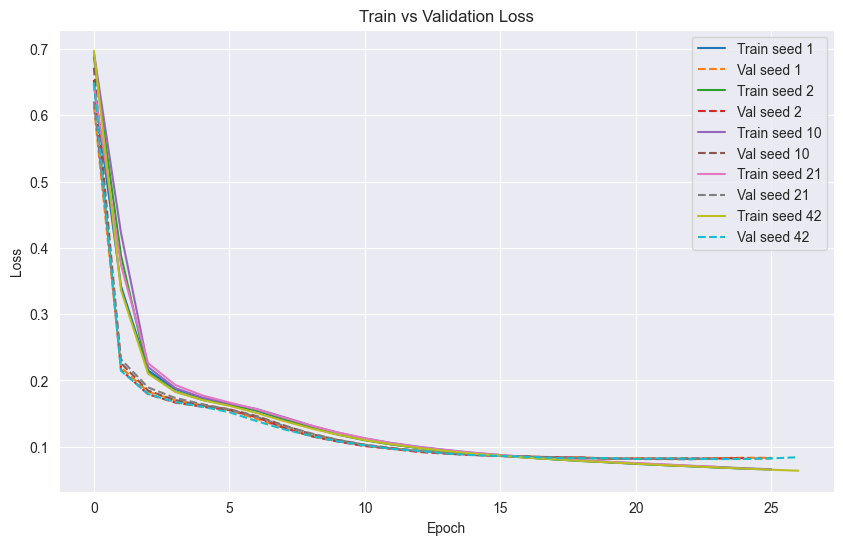

✅ Done — models + results in ./roberta_with_seance2


In [15]:
ALL_RESULTS={}
os.makedirs(SAVE_DIR,exist_ok=True)
results=[]; loss_curves={}
for seed in SEEDS:
    f1,prec,rec,tr,val=train_and_eval(seed,SAVE_DIR)
    results.append({"seed":seed,"f1":f1,"precision":prec,"recall":rec})
    loss_curves[seed]=(tr,val)
df=pd.DataFrame(results)
df.to_csv(os.path.join(SAVE_DIR,"summary.csv"), index=False)

print(df)

plt.figure(figsize=(10,6))
for seed,(tr,val) in loss_curves.items():
    plt.plot(tr,label=f"Train seed {seed}"); plt.plot(val,linestyle="--",label=f"Val seed {seed}")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"Train vs Validation Loss")
plt.legend(); plt.savefig(os.path.join(SAVE_DIR,f"loss_curves_{BACKBONE}.png"))
plt.show()
print(f"✅ Done — models + results in {SAVE_DIR}")

### Using boxplots to visualize metric distributions

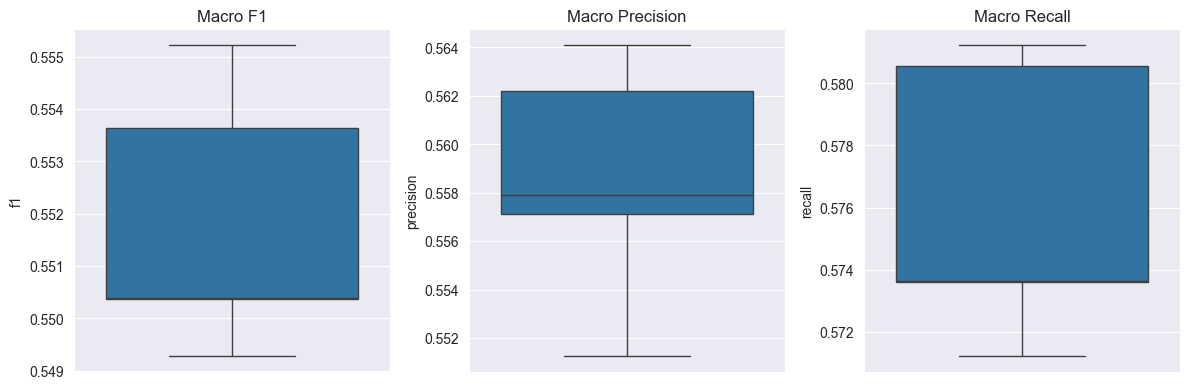

Average F1: 0.5518 ± 0.0025
Average Precision: 0.5585 ± 0.0050
Average Recall: 0.5760 ± 0.0045


In [16]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); sns.boxplot(y=df["f1"]); plt.title(f"Macro F1")
plt.subplot(1,3,2); sns.boxplot(y=df["precision"]); plt.title(f"Macro Precision")
plt.subplot(1,3,3); sns.boxplot(y=df["recall"]); plt.title(f"Macro Recall")
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR,f"metrics_boxplots_{BACKBONE}_with_seance.png"))
plt.show()

print(f"Average F1: {df['f1'].mean():.4f} ± {df['f1'].std():.4f}")
print(f"Average Precision: {df['precision'].mean():.4f} ± {df['precision'].std():.4f}")
print(f"Average Recall: {df['recall'].mean():.4f} ± {df['recall'].std():.4f}")